In [98]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization
# sequence data packages
from keras.preprocessing import sequence
import itertools
import random
import dataUtils as du
import model_utils as mutls
from sklearn import metrics

In [99]:
df=du.DataUtils.readData('cleaned_data_emission.tsv')


   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [100]:
x_str, y_wl=du.DataUtils.get_xy(df,x_col_index=9,y_col_index=8)
maxlen = du.DataUtils.get_max_len(x_str)


In [101]:
wordmap=du.DataUtils.get_wordmap(x_str)

In [102]:
len(wordmap)

42

In [103]:
x_encode=du.DataUtils.numeric_encoding(x_str,uniform_length=maxlen+5,word_map=wordmap)

In [104]:
maxlen

274

In [105]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_wl, ratio=0.2)

In [106]:
X_train

array([[ 5, 32, 32, ..., 35, 35, 35],
       [ 5, 32,  2, ..., 35, 35, 35],
       [ 5, 32, 32, ..., 35, 35, 35],
       ...,
       [ 5, 32, 18, ..., 35, 35, 35],
       [ 5, 32, 32, ..., 35, 35, 35],
       [ 5, 32, 32, ..., 35, 35, 35]], dtype=int8)

(array([93., 58., 20., 36., 24., 24., 22.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

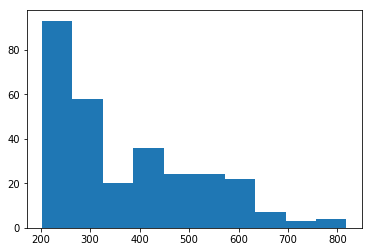

In [107]:
plt.hist(y_wl.tolist())

#### 1st model, use all data and numeric encoding of smiles, added embedding layer

In [108]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [45]:
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
lstm_5 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_6 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 279, 50)           0         
__________

In [46]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=100)

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 6s 25ms/step - loss: 154269.0291 - mean_absolute_error: 365.8581 - val_loss: 146193.4251 - val_mean_absolute_error: 352.9004
Epoch 2/100
232/232 [==============================] - 3s 13ms/step - loss: 121947.0067 - mean_absolute_error: 317.8559 - val_loss: 91614.8841 - val_mean_absolute_error: 262.2590
Epoch 3/100
232/232 [==============================] - 3s 13ms/step - loss: 63936.4386 - mean_absolute_error: 200.9835 - val_loss: 34240.5936 - val_mean_absolute_error: 139.3730
Epoch 4/100
232/232 [==============================] - 3s 13ms/step - loss: 26975.2142 - mean_absolute_error: 139.6733 - val_loss: 30032.4069 - val_mean_absolute_error: 148.4147
Epoch 5/100
232/232 [==============================] - 3s 13ms/step - loss: 27271.5331 - mean_absolute_error: 146.6160 - val_loss: 28314.3249 - val_mean_absolute_error: 118.2080
Epoch 6/100
232/232 [==============================] - 3s 13ms

Epoch 94/100
232/232 [==============================] - 4s 18ms/step - loss: 2707.2912 - mean_absolute_error: 40.2975 - val_loss: 11710.2650 - val_mean_absolute_error: 69.2264
Epoch 95/100
232/232 [==============================] - 4s 17ms/step - loss: 2499.6236 - mean_absolute_error: 37.2099 - val_loss: 9906.7375 - val_mean_absolute_error: 63.6058
Epoch 96/100
232/232 [==============================] - 3s 15ms/step - loss: 2414.1696 - mean_absolute_error: 37.2467 - val_loss: 10987.3721 - val_mean_absolute_error: 67.3879
Epoch 97/100
232/232 [==============================] - 3s 14ms/step - loss: 2211.2527 - mean_absolute_error: 35.5759 - val_loss: 10126.3528 - val_mean_absolute_error: 66.4209
Epoch 98/100
232/232 [==============================] - 3s 14ms/step - loss: 2188.4062 - mean_absolute_error: 35.1079 - val_loss: 10024.4159 - val_mean_absolute_error: 65.1970
Epoch 99/100
232/232 [==============================] - 3s 15ms/step - loss: 2092.7358 - mean_absolute_error: 33.8415 - v

### plot error after 100 epochs

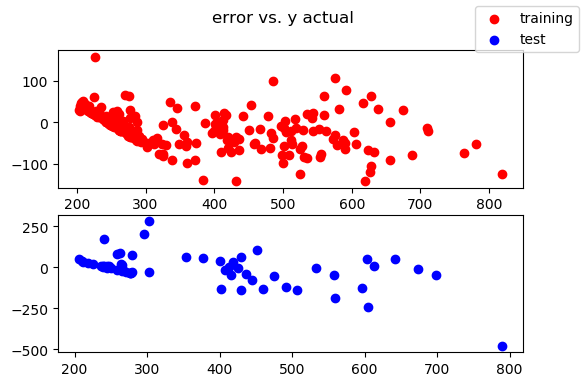

In [47]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

#### Calculate metrics after 100 epochs

In [48]:
metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train))

0.8945033837637489

In [49]:
metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test))

0.4804887724012624

In [50]:
metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train))

35.05310918084506

In [51]:
metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test))

66.29686413781117

#### another 50 epochs 

In [52]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=50)

Train on 232 samples, validate on 59 samples
Epoch 1/50
232/232 [==============================] - 3s 13ms/step - loss: 3455.1483 - mean_absolute_error: 42.6024 - val_loss: 10947.4573 - val_mean_absolute_error: 68.9825
Epoch 2/50
232/232 [==============================] - 3s 14ms/step - loss: 3355.9276 - mean_absolute_error: 41.8084 - val_loss: 8461.3985 - val_mean_absolute_error: 62.6919
Epoch 3/50
232/232 [==============================] - 3s 14ms/step - loss: 2623.5653 - mean_absolute_error: 38.6117 - val_loss: 9504.9016 - val_mean_absolute_error: 63.4574
Epoch 4/50
232/232 [==============================] - 4s 15ms/step - loss: 2587.0354 - mean_absolute_error: 37.8825 - val_loss: 8388.7515 - val_mean_absolute_error: 61.2534
Epoch 5/50
232/232 [==============================] - 3s 14ms/step - loss: 2344.6666 - mean_absolute_error: 37.0549 - val_loss: 9852.4581 - val_mean_absolute_error: 67.8470
Epoch 6/50
232/232 [==============================] - 3s 13ms/step - loss: 2207.2850 - me

Epoch 48/50
232/232 [==============================] - 3s 14ms/step - loss: 1535.9048 - mean_absolute_error: 28.1544 - val_loss: 10680.8898 - val_mean_absolute_error: 68.7111
Epoch 49/50
232/232 [==============================] - 3s 14ms/step - loss: 1360.7975 - mean_absolute_error: 27.6975 - val_loss: 9343.6686 - val_mean_absolute_error: 63.2979
Epoch 50/50
232/232 [==============================] - 3s 13ms/step - loss: 1333.0976 - mean_absolute_error: 26.9428 - val_loss: 8200.8606 - val_mean_absolute_error: 60.1830


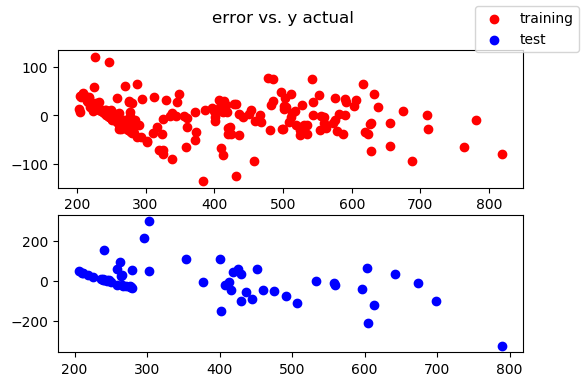

In [53]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

In [54]:
metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train))

0.9390436975774493

In [55]:
metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test))

0.6184142676059865

In [56]:
metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train))

25.93636150228566

In [57]:
metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test))

60.18302814031051

#### another 25 epochs 

In [59]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=25)

Train on 232 samples, validate on 59 samples
Epoch 1/25
232/232 [==============================] - 3s 13ms/step - loss: 1107.1168 - mean_absolute_error: 24.2664 - val_loss: 9444.8452 - val_mean_absolute_error: 63.2462
Epoch 2/25
232/232 [==============================] - 3s 13ms/step - loss: 1074.5614 - mean_absolute_error: 23.9291 - val_loss: 9548.1624 - val_mean_absolute_error: 62.6037
Epoch 3/25
232/232 [==============================] - 3s 13ms/step - loss: 1033.6848 - mean_absolute_error: 23.4231 - val_loss: 9296.1054 - val_mean_absolute_error: 62.4990
Epoch 4/25
232/232 [==============================] - 3s 13ms/step - loss: 1002.1034 - mean_absolute_error: 23.7485 - val_loss: 8938.2814 - val_mean_absolute_error: 60.0269
Epoch 5/25
232/232 [==============================] - 3s 13ms/step - loss: 1111.6081 - mean_absolute_error: 23.8538 - val_loss: 9492.7164 - val_mean_absolute_error: 64.5240
Epoch 6/25
232/232 [==============================] - 3s 13ms/step - loss: 1052.8282 - mea

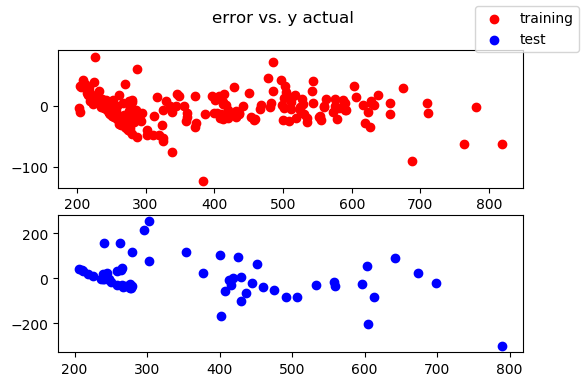

In [60]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)

In [62]:
print("train R2 is %s" % metrics.r2_score(y_train.reshape(-1,1),model.predict(X_train)))
print("test R2 is %s" % metrics.r2_score(y_test.reshape(-1,1),model.predict(X_test)))

train R2 is 0.9681928487601932
test R2 is 0.6416524410660247


In [63]:
print("train mean abs err is %s" % metrics.mean_absolute_error(y_train.reshape(-1,1),model.predict(X_train)))
print("test mean abs err is %s" % metrics.mean_absolute_error(y_test.reshape(-1,1),model.predict(X_test)))

train mean abs err is 18.85860572551859
test mean abs err is 60.34719202073954


After 175 epochs total, train absolute error ~18nm, val absolute error ~60

#### plot error of the model

### Model 2 consider transform y to make y more normal distributed, resulted in more error

In [64]:
def tranform_log(x_list, b): #log(x-b)
    return np.log(list(x_list-b))

In [65]:
y_log = tranform_log(y_wl,y_wl.min()-10)

In [66]:
def inverse_log(transformed_x,b):
    return np.exp(transformed_x)+b

In [67]:
inverse_log(y_log, y_wl.min()-10)

array([254.75, 261.75, 263.  , 265.  , 275.  , 265.  , 278.  , 271.  ,
       271.  , 270.75, 220.  , 222.  , 242.  , 227.  , 241.  , 288.  ,
       251.  , 279.  , 265.  , 228.  , 258.  , 248.  , 236.  , 274.  ,
       277.  , 227.  , 222.  , 218.  , 310.25, 291.  , 240.  , 251.  ,
       263.  , 245.  , 302.  , 252.  , 283.  , 225.  , 316.  , 230.  ,
       442.  , 247.5 , 276.25, 294.75, 312.  , 251.  , 206.  , 209.  ,
       212.  , 302.75, 359.  , 245.  , 223.  , 278.  , 275.  , 356.25,
       475.  , 578.  , 252.  , 241.  , 258.  , 372.5 , 270.25, 303.  ,
       228.  , 239.  , 245.  , 218.  , 227.  , 235.  , 278.75, 276.  ,
       293.75, 326.  , 330.  , 353.25, 432.25, 425.  , 372.  , 451.  ,
       251.  , 276.  , 227.  , 257.  , 265.  , 270.  , 215.  , 281.  ,
       238.  , 204.  , 219.  , 245.  , 217.  , 253.  , 231.75, 206.  ,
       278.  , 502.  , 413.  , 286.  , 336.  , 460.5 , 219.  , 413.  ,
       247.  , 349.  , 262.  , 257.5 , 274.25, 211.  , 278.  , 261.  ,
      

(array([ 7.,  6., 15., 23., 57., 39., 21., 46., 55., 22.]),
 array([2.30258509, 2.71610175, 3.1296184 , 3.54313506, 3.95665172,
        4.37016837, 4.78368503, 5.19720168, 5.61071834, 6.02423499,
        6.43775165]),
 <a list of 10 Patch objects>)

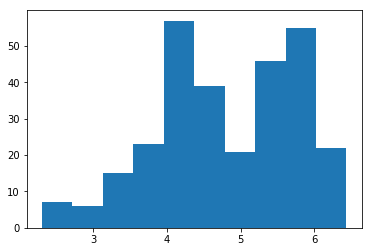

In [68]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_log, ratio=0.2)
plt.hist(y_log.tolist())

In [115]:
from keras import backend as K

In [124]:
def mean_abs_exp_error(y_true, y_pred):    
    from keras import backend as K
    first_exp = K.exp(y_pred)
    second_exp = K.exp(y_true)    
    return K.mean(K.abs(first_exp - second_exp), axis=-1)

In [125]:
model.compile(loss=mean_abs_exp_error, optimizer='Adam', metrics=['mean_absolute_error'])
model.summary() ##use mean_squared_error loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
lstm_8 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 279, 50)           200       
_________________________________________________________________
lstm_9 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 279, 50)           0         
__________

In [126]:
model.fit(X_train, y_train.reshape(-1,1), batch_size=32, validation_data=(X_test, y_test.reshape(-1,1)), epochs=50)

Train on 232 samples, validate on 59 samples
Epoch 1/50
232/232 [==============================] - 7s 32ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/50
232/232 [==============================] - 3s 13ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/50
232/232 [==============================] - 3s 13ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/50
232/232 [==============================] - 3s 13ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/50
232/232 [==============================] - 3s 13ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/50
232/232 [==============================] - 3s 13ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/50
232/232 [=================

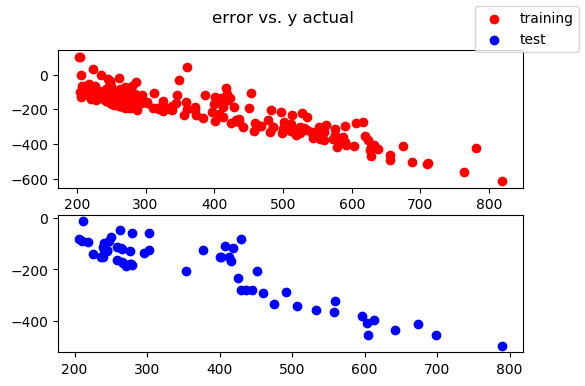

In [114]:
mutls.ModelUtils.plot_model_error(X_train, X_test, y_train, y_test, model)


In [75]:
y_train_pred_wl = inverse_log(model.predict(X_train), y_wl.min()-10)

In [85]:
y_train_acutal_wl = inverse_log(y_train, y_wl.min()-10).reshape(-1,1)

In [76]:
y_test_pred_wl = inverse_log(model.predict(X_test), y_wl.min()-10)

In [87]:
y_test_acutal_wl = inverse_log(y_test, y_wl.min()-10).reshape(-1,1)

Text(0.5, 0.98, 'error vs. y actual')

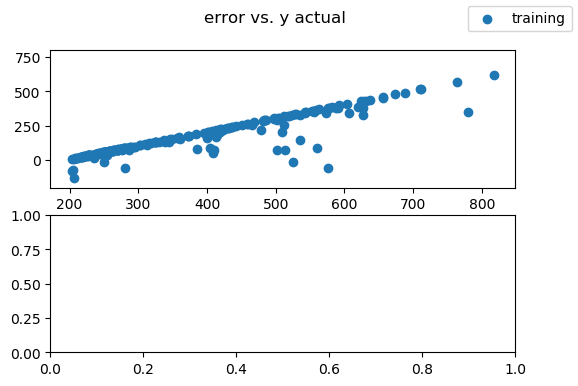

In [95]:
fig, axes = plt.subplots(2)
fig.dpi=100
axes[0].scatter(y_train_acutal_wl, y_train_acutal_wl-y_train_pred_wl,label='training')
axes[0].set_ylim(-200,800)

fig.legend()
plt.suptitle("error vs. y actual" )

A lot more error at higher wavelength

### Try under sample the 200-400nm region to make the y more uniform

In [9]:
Y_category = (y_wl - 200) // 20

In [11]:
cls, counts = np.unique(Y_category, return_counts=True)
cls_counts = dict(zip(cls, counts))
print(cls_counts)

{0.0: 18, 1.0: 23, 2.0: 40, 3.0: 44, 4.0: 14, 5.0: 7, 6.0: 8, 7.0: 4, 8.0: 6, 9.0: 3, 10.0: 12, 11.0: 10, 12.0: 7, 13.0: 4, 14.0: 7, 15.0: 10, 16.0: 5, 17.0: 10, 18.0: 6, 19.0: 6, 20.0: 6, 21.0: 3, 22.0: 4, 23.0: 2, 24.0: 2, 25.0: 2, 28.0: 1, 29.0: 2, 30.0: 1}


#### To each category, keep less than 20 counts per category

In [40]:
data_cat=np.column_stack((x_str,y_wl,Y_category))

In [61]:
def subsampling(dataset, cls_max, cls_dict):
    out = []
    for row in dataset:
        cls = row[2]
        rInt = np.random.randint(0, cls_dict[cls])
        if rInt <= cls_max:
            out.append(row)
    return np.array(out)

subsampled = subsampling(data_cat, 10, cls_counts)

In [62]:
subsampled[:,1].shape

(189,)

In [63]:
x_encode=du.DataUtils.numeric_encoding(subsampled[:,0],uniform_length=maxlen+5,word_map=wordmap)

In [64]:
y_sub = subsampled[:,1]

(array([41., 29., 18., 25., 21., 23., 18.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

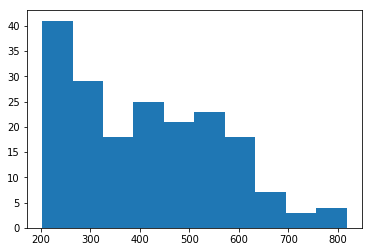

In [67]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_sub, ratio=0.15)
plt.hist(y_sub.tolist())

In [70]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 279, 50)           2250      
_________________________________________________________________
lstm_4 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 279, 50)           2550      
_________________________________________________________________
flatten_2 (Flatten)          (None, 13950)             0         
__________

In [71]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=50)

Train on 160 samples, validate on 29 samples
Epoch 1/50
160/160 [==============================] - 4s 26ms/step - loss: 198562.2719 - mean_absolute_error: 419.9061 - val_loss: 164067.7656 - val_mean_absolute_error: 379.2515
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 193748.8687 - mean_absolute_error: 413.9373 - val_loss: 150534.7188 - val_mean_absolute_error: 360.8287
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 157656.6547 - mean_absolute_error: 366.3126 - val_loss: 92568.8984 - val_mean_absolute_error: 268.7489
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 83147.7500 - mean_absolute_error: 246.3115 - val_loss: 35154.0078 - val_mean_absolute_error: 133.5898
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 30540.1109 - mean_absolute_error: 139.6379 - val_loss: 26367.6211 - val_mean_absolute_error: 143.5896
Epoch 6/50
160/160 [==============================] - 2s 11ms/ste

Epoch 47/50
160/160 [==============================] - 2s 14ms/step - loss: 22313.2809 - mean_absolute_error: 126.6933 - val_loss: 21134.8574 - val_mean_absolute_error: 130.9054
Epoch 48/50
160/160 [==============================] - 2s 14ms/step - loss: 22432.8074 - mean_absolute_error: 126.7174 - val_loss: 20603.0156 - val_mean_absolute_error: 129.8223
Epoch 49/50
160/160 [==============================] - 2s 14ms/step - loss: 22217.7729 - mean_absolute_error: 125.7395 - val_loss: 20892.5215 - val_mean_absolute_error: 130.4620
Epoch 50/50
160/160 [==============================] - 2s 14ms/step - loss: 22078.0854 - mean_absolute_error: 125.7653 - val_loss: 21381.2891 - val_mean_absolute_error: 131.6530
